# segmented wing 

this jupyter notebook contains the aeroelastic matrices written for a torsionally elastic straight wing with three different discretizations: (a) the wing is cut into n rigid segments, connected to each other with a rotational spring, (b) a FEM with only beam elements, (c) a model obtained from the Ritz-Rayleigh approach.

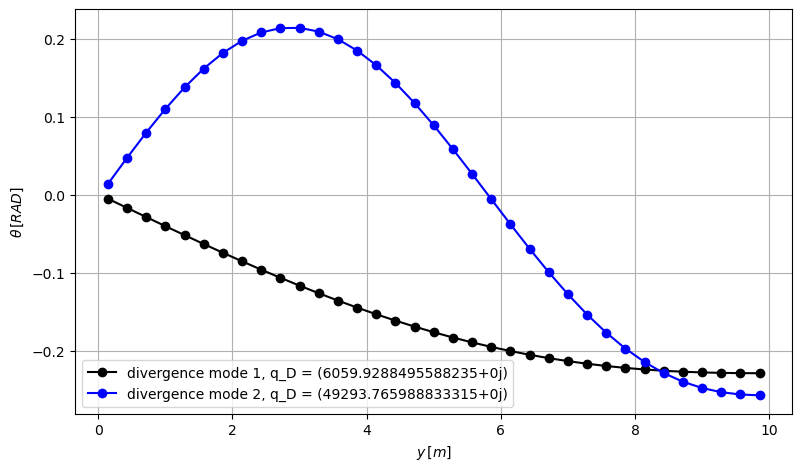

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

cla = 2*np.pi
chord = 1.
cm0 = 0.01
cl0 = 0.10 
e = 0.2*chord
alpha_0 = 2.0*np.pi/180.

n_segments = 35 

span = 10. 
span_segment = span/n_segments
area_segment = chord*span_segment
y_segments = np.linspace(span_segment*0.5,span-0.5*span_segment,n_segments)
tip_loss = np.sqrt(1-(y_segments/span)**2)

GJ = 200000.
k_theta = GJ/span_segment

k = k_theta*(2*np.diag(np.ones(n_segments))-np.diag(np.ones(n_segments-1),-1)-np.diag(np.ones(n_segments-1),1))
k [0,0] += 1e6
k [n_segments-1,n_segments-1] = k_theta

ka = cla*e*area_segment*np.diag(tip_loss)

l, R = linalg.eig(linalg.inv(ka)@k)

div_mode_1 = R[:,np.argsort(l.real)[0]]
div_mode_2 = R[:,np.argsort(l.real)[1]]

fig, ax = plt.subplots()
fig.set_size_inches(9.25, 5.25)
ax.plot(y_segments,div_mode_1, 'ko-')
ax.plot(y_segments,div_mode_2, 'bo-')
ax.set_xlabel(r'$y\,[m]$')        
ax.set_ylabel(r'$\theta\,[RAD]$')        
ax.legend(['divergence mode 1, q_D = '+str(l[np.argsort(l.real)[0]]),'divergence mode 2, q_D = '+str(l[np.argsort(l.real)[1]])])
ax.grid()
plt.show()


In [33]:
rho = 1.2
v = 100. 

ma = 0.5*rho*v**2 * area_segment*e*tip_loss*cla*alpha_0

theta = linalg.inv(k)@ma 

#fig, ax = plt.subplots()
#fig.set_size_inches(9.25, 5.25)
#ax.plot(y_segments,theta, 'ko-')
#ax.set_xlabel(r'$y\,[m]$')        
#ax.set_ylabel(r'$\theta\,[RAD]$')        
#ax.grid()
#plt.show()

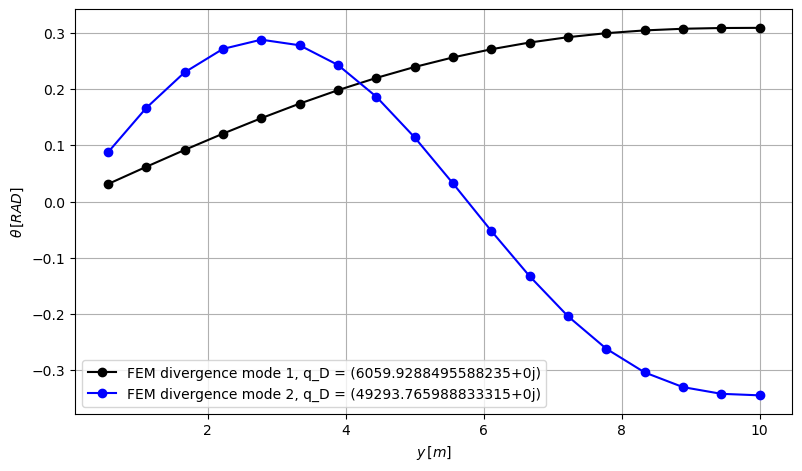

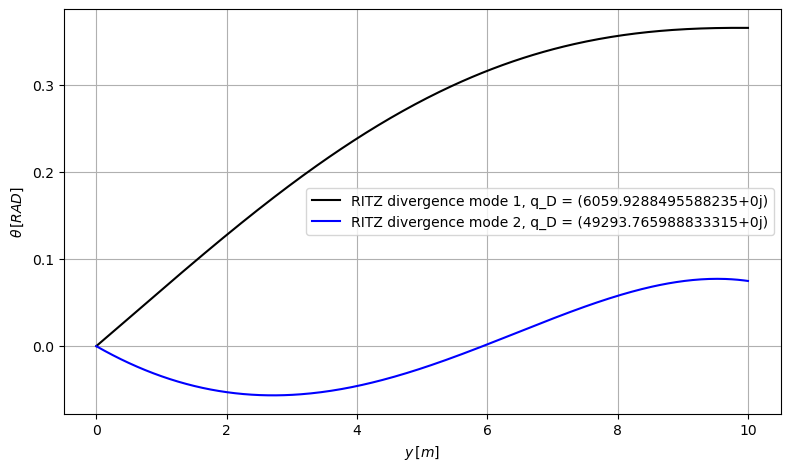

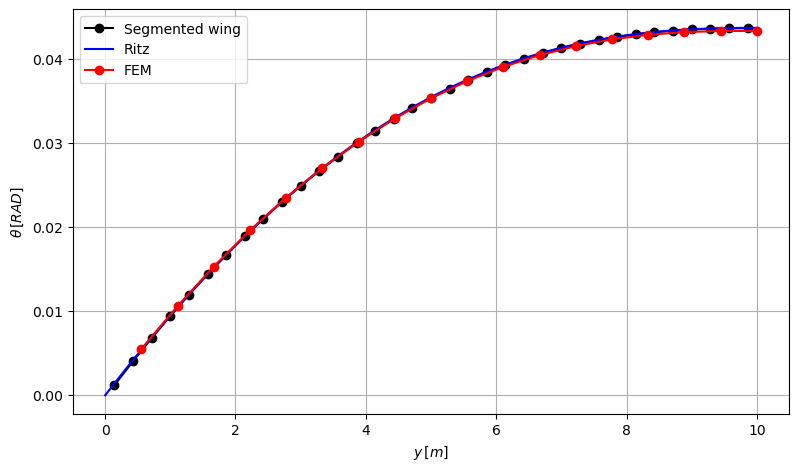

In [34]:
# check with FE 


n_elements = 18
span_element = span/n_elements
area_element = chord*span_element

k_element = GJ/span_element * np.array([[1, -1],[-1, 1]])
ka_element = area_element*e*cla * np.array([[1/3, 1/6],[1/6, 1/3]])

n_nodes = n_elements + 1
y_node = np.linspace(0.,span,n_nodes)
tip_loss_nodes = np.sqrt(1-(y_node/span)**2)

k_fem = np.zeros((n_nodes,n_nodes))
ka_fem = np.zeros((n_nodes,n_nodes))

for i_element in range(n_elements):
    k_fem[i_element:i_element+2,i_element:i_element+2] += k_element
    ka_fem[i_element:i_element+2,i_element:i_element+2] += ka_element*0.5*(tip_loss_nodes[i_element]+tip_loss_nodes[i_element+1])

k_fem_a = k_fem[1:,1:]
ka_fem_a = ka_fem[1:,1:]

l_fem, R_fem = linalg.eig(linalg.inv(ka_fem_a)@k_fem_a)

div_mode_1 = R_fem[:,np.argsort(l_fem.real)[0]]
div_mode_2 = R_fem[:,np.argsort(l_fem.real)[1]]

fig, ax = plt.subplots()
fig.set_size_inches(9.25, 5.25)
ax.plot(y_node[1:],div_mode_1, 'ko-')
ax.plot(y_node[1:],div_mode_2, 'bo-')
ax.set_xlabel(r'$y\,[m]$')        
ax.set_ylabel(r'$\theta\,[RAD]$')        
ax.legend(['FEM divergence mode 1, q_D = '+str(l[np.argsort(l.real)[0]]),'FEM divergence mode 2, q_D = '+str(l[np.argsort(l.real)[1]])])
ax.grid()
plt.show()

m_fem = 0.5*rho*v**2 * area_element*e*tip_loss_nodes*cla*alpha_0
m_fem[n_nodes-1] = 0.50*m_fem[n_nodes-1]
m_fem_a = m_fem[1:]

theta_fem = linalg.inv(k_fem_a)@m_fem_a

# check with Ritz-Rayleigh

n_fine = 320
y_fine = np.linspace(0.,span,n_fine)
tip_loss_fine = np.sqrt(1-(y_fine/span)**2)


phi1 = (y_fine/span)
phi2 = (y_fine/span)**2
phi3 = (y_fine/span)**3
phi4 = (y_fine/span)**4

phi = np.zeros((n_fine,4)) 

phi[:,0] = phi1
phi[:,1] = phi2
phi[:,2] = phi3
phi[:,3] = phi4

dphi_dy = np.zeros((n_fine,4)) 

dphi_dy[:,0] = np.gradient(phi1,y_fine)
dphi_dy[:,1] = np.gradient(phi2,y_fine)
dphi_dy[:,2] = np.gradient(phi3,y_fine)
dphi_dy[:,3] = np.gradient(phi4,y_fine)

k_ritz = GJ*dphi_dy.T@dphi_dy*(span/n_fine)
ka_ritz = e*cla*( (tip_loss_fine.reshape((n_fine,1))@np.ones((1,4))).T*phi.T)@phi*(span/n_fine)

l_ritz, R_ritz = linalg.eig(linalg.inv(ka_ritz)@k_ritz)

div_mode_1 = phi@R_ritz[:,np.argsort(l_ritz.real)[0]]
div_mode_2 = phi@R_ritz[:,np.argsort(l_ritz.real)[1]]


fig, ax = plt.subplots()
fig.set_size_inches(9.25, 5.25)
ax.plot(y_fine,div_mode_1, 'k-')
ax.plot(y_fine,div_mode_2, 'b-')
ax.set_xlabel(r'$y\,[m]$')        
ax.set_ylabel(r'$\theta\,[RAD]$')        
ax.legend(['RITZ divergence mode 1, q_D = '+str(l[np.argsort(l.real)[0]]),'RITZ divergence mode 2, q_D = '+str(l[np.argsort(l.real)[1]])])
ax.grid()
plt.show()

ma =  0.5*rho*v**2 *cla*e*alpha_0*tip_loss_fine.reshape((n_fine,1)) #np.ones((n_fine,1))

ma_ritz = phi.T@ma

a = linalg.inv(k_ritz)@ma_ritz *(span/n_fine)

theta_ritz = phi@a

fig, ax = plt.subplots()
fig.set_size_inches(9.25, 5.25)
ax.plot(y_segments,theta, 'ko-')
ax.plot(y_fine,theta_ritz, 'b-')
ax.plot(y_node[1:],theta_fem, 'ro-')
ax.set_xlabel(r'$y\,[m]$')        
ax.set_ylabel(r'$\theta\,[RAD]$') 
ax.legend(['Segmented wing','Ritz','FEM'])
ax.grid()
plt.show()


# 